In [1]:
import os
import pdb
import glob
import string
import numpy as np
import pandas as pd
import pickle as pkl
from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros
from random import randint
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load doc into memory
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc, vocab):
    # split into tokens by white space
    doc = doc.rstrip()
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation + '\n')
    tokens = [w.translate(table) for w in tokens]
    # filter out tokens not in vocab
    tokens = [w for w in tokens if w in vocab]
    tokens = ' '.join(tokens)
    tokens = ' '.join(tokens.split())
    return tokens   
    
# load all docs in a directory
def process_docs(directory, vocab, label):
    df = pd.DataFrame(columns=('text', 'label', 'wordcount'))
    # walk through all files in the folder
    x = 0
    for filename in listdir(directory):
        # create the full path of the file to open
        path = directory + '/' + filename
        # load the doc
        doc = load_doc(path)
        # clean doc
        tokens = clean_doc(doc, vocab)
        # add to list
        wordcount = len(tokens.split())
        df = df.append({'text': tokens, 'label': label, 'wordcount': wordcount}, ignore_index=True)  
    return df

def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r', encoding="utf8")
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    wordList = []
    wordVectors = []    
    for line in lines:
        parts = line.split()
        wordList.append(parts[0])
        wordVectors.append(asarray(parts[1:], dtype='float32'))
    return wordList, asarray(wordVectors, dtype='float32')


# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, 300))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix


In [3]:
# load embedding from file
wordList, wordVectors = load_embedding('data/movie_embeddings_word2vec.txt')

In [4]:
print(wordList[1:10])
print(wordVectors.shape)
print(type(wordVectors))
print(wordVectors)

['one', 'movie', 'like', 'even', 'good', 'time', 'story', 'films', 'would']
(44276, 300)
<class 'numpy.ndarray'>
[[-1.6218376e-01  5.5648273e-01 -2.7849936e-01 ...  1.8042541e-01
  -2.0689143e-01 -5.5061924e-01]
 [-2.1016115e-01  3.1511781e-01 -3.4155941e-01 ...  2.1078728e-01
  -2.4634373e-01 -3.4251076e-01]
 [-1.4809293e-01  6.1345339e-01 -1.4910689e-01 ...  2.7480820e-01
  -2.3152344e-01 -5.6512904e-01]
 ...
 [-2.8129460e-03  2.0595028e-03 -2.8118331e-03 ...  3.2124331e-03
  -3.4316683e-03 -7.1255555e-03]
 [-1.6010485e-03  1.7018503e-03 -9.0302055e-04 ...  1.6910424e-04
  -6.4556394e-04 -1.4916587e-03]
 [-3.6617904e-03  2.4671869e-03 -4.3901941e-03 ...  8.2240645e-03
  -3.9786389e-03 -1.1202857e-02]]


In [5]:
# load the vocabulary
vocab_filename = 'data/movie_vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

In [6]:
# load all training reviews
positive_docs = process_docs('data/txt_sentoken/pos', vocab, 1)
negative_docs = process_docs('data/txt_sentoken/neg', vocab, 0)
corpus = pd.concat([positive_docs, negative_docs])

In [7]:
print(corpus.head())
print(corpus.tail())
print()
print('Total number of cases =', corpus['text'].count())
print(corpus.groupby('label').label.count())
print('Average number of words in a file =', corpus.wordcount.mean())

                                                text label wordcount
0  films adapted comic books plenty success wheth...     1       402
1  every movie comes along suspect studio every i...     1       356
2  youve got mail works alot better deserves orde...     1       211
3  jaws rare film grabs attention shows single im...     1       561
4  moviemaking lot like general manager nfl team ...     1       371
                                                  text label wordcount
995  anything stigmata taken warning releasing simi...     0       668
996  john boormans goofy cinematic debacle fundamen...     0       504
997  kids hall acquired taste took least season wat...     0       200
998  time john carpenter great horror director cour...     0       267
999  two party guys bob heads haddaways dance hit l...     0       273

Total number of cases = 2000
label
0    1000
1    1000
Name: label, dtype: int64
Average number of words in a file = 350.0125


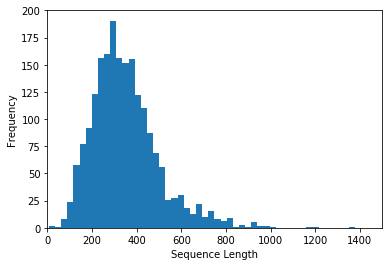

In [8]:
plt.hist(corpus['wordcount'].tolist(), 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1500, 0, 200])
plt.show()

In [9]:
maxSeqLength = 600
numFiles = corpus['text'].count()

In [10]:
ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
positiveCases = corpus.loc[corpus['label'] == 1]
negativeCases = corpus.loc[corpus['label'] == 0]
caseCounter = 0
for index, row in positiveCases.iterrows():
    indexCounter = 0
    line=row['text']
    split = line.split()
    for word in split:
        try:
            ids[caseCounter][indexCounter] = wordList.index(word)
        except ValueError:
            ids[caseCounter][indexCounter] = 399999 #Vector for unkown words
            print(word)
        indexCounter = indexCounter + 1
        if indexCounter >= maxSeqLength:
            break
    caseCounter = caseCounter + 1 

for index, row in negativeCases.iterrows():
    indexCounter = 0
    line=row['text']
    split = line.split()
    for word in split:
        try:
            ids[caseCounter][indexCounter] = wordList.index(word)
        except ValueError:
            ids[caseCounter][indexCounter] = 399999 #Vector for unkown words
            print(word)
        indexCounter = indexCounter + 1
        if indexCounter >= maxSeqLength:
            break
    caseCounter = caseCounter + 1 
#np.save('idsMatrix', ids)

In [11]:
print("Positive Cases: ", positiveCases.label.count())
print("Negative Cases: ", negativeCases.label.count())
positiveCases.head()

Positive Cases:  1000
Negative Cases:  1000


,text,label,wordcount
0,films adapted comic books plenty success wheth...,1,402
1,every movie comes along suspect studio every i...,1,356
2,youve got mail works alot better deserves orde...,1,211
3,jaws rare film grabs attention shows single im...,1,561
4,moviemaking lot like general manager nfl team ...,1,371


In [12]:
def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,800)
            labels.append([1,0])
        else:
            num = randint(1200,2000)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0):
            num = randint(800,1000)
            labels.append([1,0])
        else:
            num = randint(1000,1200)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

In [13]:
batchSize = 24
lstmUnits = 64
numClasses = 2
iterations = 10001
numDimensions = 300

#### Create placeholders for the input data and labels

In [14]:
import tensorflow as tf
tf.reset_default_graph()
labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

#### Create a variable that will hold the input data in 3-D (batchsize, sequence length, word embedding dimension). Also map word indexes to word embeddings.

In [15]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors,input_data)

#### The tf.nn.rnn_cell.BasicLSTMCell function takes in an integer for the number of LSTM units. Tune this hyperparameter! Wrap that LSTM cell in a dropout layer to help prevent the network from overfitting. The tf.nn.dynamic_rnn function will unroll the whole network and create a pathway for the data to flow through the RNN graph.

In [16]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=keep_prob)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

In [17]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

In [18]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

In [19]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [20]:
import datetime
tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
with tf.Session() as sess:
    writer = tf.summary.FileWriter(logdir, sess.graph)

In [ ]:
sess = tf.InteractiveSession()
saver = tf.train.Saver(max_to_keep=10000)
sess.run(tf.global_variables_initializer())

for i in range(iterations):
   #Next Batch of reviews
   nextBatch, nextBatchLabels = getTrainBatch();
   sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels, keep_prob: 0.75})

   #Write summary to Tensorboard
   if (i % 50 == 0):
       summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels, keep_prob: 0.75})
       writer.add_summary(summary, i)

             #Save the network every 10,000 training iterations
   if (i % 500 == 0 and i != 0):
       save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
       print("saved to %s" % save_path)
       acc = []
       for j in range(100):
            testBatch, testBatchLabels = getTestBatch()
            batch_accuracy = sess.run(accuracy, {input_data: testBatch, labels: testBatchLabels, keep_prob: 1}) * 100
            acc.append(batch_accuracy)
       print("Accuracy: ", np.mean(acc)) 
writer.close()

saved to models/pretrained_lstm.ckpt-500
Accuracy:  50.0
saved to models/pretrained_lstm.ckpt-1000
Accuracy:  50.0
saved to models/pretrained_lstm.ckpt-1500
Accuracy:  49.833334028720856
saved to models/pretrained_lstm.ckpt-2000
Accuracy:  50.58333399891853
saved to models/pretrained_lstm.ckpt-2500
Accuracy:  49.41666725277901


In [ ]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, 'models/pretrained_lstm.ckpt-2000')
#saver.restore(sess, tf.train.latest_checkpoint('models'))

In [ ]:
iterations = 100
acc = []
truth = []
pred = []
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    z = sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels, keep_prob: 1.0}) * 100
    p = sess.run(tf.argmax(prediction,1), {input_data: nextBatch, labels: nextBatchLabels, keep_prob: 1.0}) * 100
    truth.extend((np.argmax(nextBatchLabels, 1) * 100))
    pred.extend(p)
    #    print("Accuracy for this batch:", z)
    acc.append(z)
#    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)
print(np.mean(acc))

In [ ]:
cont = []
#print(truth)
#print(pred)
cont.append([np.array(truth), np.array(pred)])
best = cont[0]
rf_ct = pd.crosstab(best[1], best[0], margins=True)
rf_ct.columns = ["-'ve", "+'ve", "Total"]
rf_ct.index = ["-'ve", "+'ve", "Total"]
print(rf_ct)

Sens = rf_ct.iloc[1][1]/rf_ct.iloc[2][1]
Spec = rf_ct.iloc[0][0]/rf_ct.iloc[2][0]
PPV = rf_ct.iloc[1][1]/rf_ct.iloc[1][2]
NPV = rf_ct.iloc[0][0]/rf_ct.iloc[0][2]
ACC = (rf_ct.iloc[0][0] + rf_ct.iloc[1][1]) / rf_ct.iloc[2][2]
print("Random Forest: Sensitivity: %.2f Specificity: %.2f PPV: %.2f NPV: %.2f Accuracy: %.2f" % (Sens, Spec, PPV, NPV, ACC))

In [ ]:
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pylab import barh,plot,yticks,show,grid,xlabel,figure

rf_fpr, rf_tpr, rf_thresholds = roc_curve(best[0], best[1], pos_label=100)
roc_auc = auc(rf_fpr, rf_tpr)
plt.rcdefaults()
plt.figure(figsize=(4,4))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rf_fpr, rf_tpr, label='RNN')
plt.xlabel('False positive rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
print("AUC = ", roc_auc)

In [ ]:
print(rf_fpr)
print(rf_tpr)
print(rf_thresholds) 